## 基本情報（ディレクトリ含む）

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image
import cv2
import pandas as pd

# directoryとfile名のリスト
dirs=('seong07-200422-w1118.F.ST',
      'seong08-200429-w1118.ST.all-free',
      'seong09-200429.w1118.M.ST')
fnames=(('seong07-200422-w1118.F.ST-back.mp4',
         'vi_0001_20200429_110751.mp4',
         'vi_0002_20200430_110751.mp4',
         'vi_0003_20200501_110751.mp4'),
        ('vi_0001_20200429_094729.mp4',
         'vi_0002_20200429_104150.mp4',
         'vi_0003_20200430_104150.mp4',
         'vi_0004_20200501_104150.mp4'),
        ('vi_0000_20200429_104213-back.mp4',
         'vi_0001_20200429_112841.mp4',
         'vi_0002_20200430_112841.mp4',
         'vi_0003_20200501_112841.mp4')
       )



## 動画をウェルごとにCropする（上書き注意）

In [ ]:
import ffmpeg

dnummax=3
fmax=4

for dnum in range(dnummax):
    for f in range(fmax):

        fnum=f

        dirname=dirs[dnum]
        fname=fnames[dnum][fnum]
        filepath=dirname+'/'+fname
        tpoint = 0
        # 取り出したい静止画の時間（tpoint = 10 なら動画の10秒時点の静止画が取れる）
        imagename = filepath+'.jpg'
        #取り出したい静止画のファイル名を指定

        print('IN Movie File:{}'.format(filepath))
        print('OUT Image File:{}'.format(imagename))
        #sys.exit()
        stream = ffmpeg.input(filepath)
        #stream = ffmpeg.input('sample.mp4')
        # sample.mp4に切り取りたい動画を入れる

        stream = ffmpeg.output(stream, imagename, ss=tpoint, vframes=1, f='image2')
        ffmpeg.run(stream,overwrite_output=True)

        imgorg=Image.open(imagename)
        img=imgorg.convert('L')
        img=np.asarray(img)
        plt.imshow(imgorg)

        wnum=6; # wellの数
        nx=3; # wellの横方向の数
        ny=2 # wellの縦方向の数
        
        # well切り出しのためのデフォルト座標
        x0=0; y0=50; drx=105; dry=105; dw=2
        dx=drx*2; dy=dry*2

        mask=np.ones((img.shape[0],img.shape[1]))*(-1)
        masked_img=np.zeros((dy,dx,wnum))
        locs=np.zeros((wnum,4))
        for i in range(wnum):
            x1=x0+np.mod(i,nx)*(drx*2+dw)
            
            # 以下は、ウェル切り出しのための微調整。動画ごとのマニュアルチューニング
            y1=y0+np.mod(i,ny)*(dry*2+dw)
            if dnum==0:
                if i==0: y1=y1+2
                if i==1: y1=y1-2
                if i==2: x1=x1-4
                if i==4: y1=y1+3
                if i==5: y1=y1-2; x1=x1-1
            elif dnum==1:
                if i==0: y1=y1+5; x1=x1+5
                if i==1: y1=y1; x1=x1+7
                if i==2: y1=y1; x1=x1
                if i==3: y1=y1; x1=x1+6
                if i==4: y1=y1; x1=x1+4
                if i==5: y1=y1-4; x1=x1+3
            elif dnum==2:
                if i==0: y1=y1; x1=x1+5
                if i==1: y1=y1-1; x1=x1
                if i==2: y1=y1; x1=x1-2
                if i==3: y1=y1-4; x1=x1+3
                if i==4: y1=y1; x1=x1+2
                if i==5: y1=y1-4; x1=x1



            x2=x1+drx*2
            y2=y1+dry*2
            locs[i,:]=[x1,y1,x2-x1,y2-y1]
            cntr=0
            for y in range(y1,y2):
                mask[y,x1:x2]=i
                masked_img[cntr,:,i]=img[y,x1:x2]
                cntr+=1
        #plt.figure()
        #plt.imshow(mask)

        # サンプル画像を表示
        plt.figure()
        for i in range(wnum):
            #ind=np.where(mask==i)[0]
            #im=img[ind].reshape(dy,dx)
            plt.subplot(ny,nx,i+1)
            plt.imshow(masked_img[:,:,i])

        plt.show()

        #sys.exit()
        for i in range(wnum):

            f_head='.'.join(fname.split('.')[:-1])
            f_tail=fname.split('.')[-1]
            out_fname=dirname+'/'+f_head+'-well{}.'.format(str(i))+f_tail
            print(out_fname)
            #sys.exit()
            stream = ffmpeg.input(filepath)
            # sample.mp4に切り取りたい動画を入れる

            stream = ffmpeg.crop(stream, *locs[i,:])
            #stream = ffmpeg.crop(stream, upper_left_x, upper_left_y, width, height)
            stream = ffmpeg.output(stream, out_fname)
            # cropoutput.mp4が切り取った動画で出てきます。

            ffmpeg.run(stream, overwrite_output=True)
            # overwrite_output=Trueとすることで同じファイル名の動画がすでにあっても上書きします。



## ウェルごとの動画を読み込み物体抽出（上書き注意）

In [45]:

dnummax=3
fmax=4
wmax=6

for dnum in [1]:#range(dnummax):
    dirname=dirs[dnum]

    for fnum in [1]:#range(fmax):
        fname=fnames[dnum][fnum]
        filepath=dirname+'/'+fname
        #out_fname=fname+'-fg.avi'
        #out_fname='tmp.mov'
        f_head='.'.join(fname.split('.')[:-1])
        f_tail=fname.split('.')[-1]

        for i in [0]:#range(wmax):
            in_fname=dirname+'/'+f_head+'-well{}.'.format(str(i))+f_tail
            out_fname=dirname+'/'+f_head+'-well{}-fg.'.format(str(i))+f_tail
            #sys.exit()

            print('IN File:{}'.format(in_fname))
            print('OUT File:{}'.format(out_fname))

            # 動画読み込みの設定
            movie = cv2.VideoCapture(in_fname)

            # 動画ファイル保存用の設定
            fps = int(np.round(movie.get(cv2.CAP_PROP_FPS)))          # 動画のFPSを取得
            framenum = int(movie.get(cv2.CAP_PROP_FRAME_COUNT))       # 動画のFrame数を取得
            w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))              # 動画の横幅を取得
            h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))             # 動画の縦幅を取得
            fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')       # 動画保存時のfourcc設定（mp4用）
            #fourcc = cv2.VideoWriter_fourcc(*'xvid')         # 動画保存時のfourcc設定（mp4用）
            
            # 動画の仕様（ファイル名、fourcc, FPS, サイズ）
            video = cv2.VideoWriter(out_fname, fourcc, fps, (w, h), False) 
            print('fps={},#frame={},w={},h={}'.format(fps,framenum,w,h))
            
            # 背景差分の設定
            #fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()       # 背景オブジェクトを作成
            fgbg = cv2.createBackgroundSubtractorMOG2()              # 背景オブジェクトを作成

            # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
            cntr=0
            while True:
                ret, frame = movie.read()                                  # フレームを取得
                if not ret:
                    print('Finish!')
                    break

                #fgmask = fgbg.apply(frame)                  # 前景領域のマスクを取得する
                #video.write(fgmask)                         # 動画を保存する
                video.write(frame)
                    
                if cntr%10000==0:
                    print('cntr={}/{}'.format(cntr,framenum))

                cntr+=1
                # フレームが取得できない場合はループを抜ける


IN File:seong08-200429-w1118.ST.all-free/vi_0002_20200429_104150-well0.mp4
OUT File:seong08-200429-w1118.ST.all-free/vi_0002_20200429_104150-well0-fg.mp4
fps=30,#frame=2589631,w=210,h=210
skipnum=10000
cntr=0/2589631
cntr=10000/2589631
break!


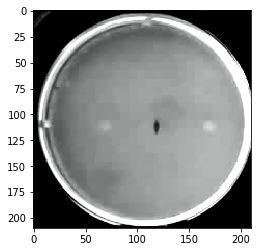

In [46]:
plt.imshow(frame)

In [48]:
#print(out_fname)
b=cv2.VideoCapture('./vi_0000_20200429_104213-back.mp4')
b=cv2.VideoCapture(out_fname)
print(b.get(cv2.CAP_PROP_FPS))
print(b.get(cv2.CAP_PROP_FRAME_COUNT))
print(b.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(b.get(cv2.CAP_PROP_FRAME_WIDTH))
b.get(cv2.CAP_PROP_FOURCC)

0.0
0.0
0.0
0.0


0.0

In [22]:
tmparr=np.zeros((210,210))
tmparr=tmparr.astype('uint8')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
a = cv2.VideoWriter('tmp.mp4', fourcc, 3.0, (210, 210), False)
a.write(tmparr)
print(a.get(cv2.CAP_PROP_FPS))
print(a.get(cv2.CAP_PROP_FRAME_COUNT))
print(a.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(a.get(cv2.CAP_PROP_FRAME_WIDTH))

0.0
0.0
0.0
0.0


In [23]:
a.get(cv2.CAP_PROP_FPS)

0.0

## 動画のFPSなどを一覧表示するだけのスクリプト 

In [ ]:
dnummax=3
fmax=4
wmax=6

for dnum in range(dnummax):
    dirname=dirs[dnum]

    for fnum in range(fmax):
        fname=fnames[dnum][fnum]
        filepath=dirname+'/'+fname
        #out_fname=fname+'-fg.avi'
        #out_fname='tmp.mov'
        f_head='.'.join(fname.split('.')[:-1])
        f_tail=fname.split('.')[-1]

        for i in range(wmax):
            in_fname=dirname+'/'+f_head+'-well{}.'.format(str(i))+f_tail
            out_fname=dirname+'/'+f_head+'-well{}-fg.'.format(str(i))+f_tail
            

            # 動画読み込みの設定
            movie1 = cv2.VideoCapture(in_fname)
            movie2 = cv2.VideoCapture(out_fname)

            fps1 = int(movie1.get(cv2.CAP_PROP_FPS))                  # 動画のFPSを取得
            framenum1 = int(movie1.get(cv2.CAP_PROP_FRAME_COUNT))     # 動画のFrame数を取得
            w1 = int(movie1.get(cv2.CAP_PROP_FRAME_WIDTH))            # 動画の横幅を取得
            h1 = int(movie1.get(cv2.CAP_PROP_FRAME_HEIGHT))           # 動画の縦幅を取得
            
            fps2 = int(movie2.get(cv2.CAP_PROP_FPS))                  # 動画のFPSを取得
            framenum2 = int(movie2.get(cv2.CAP_PROP_FRAME_COUNT))     # 動画のFrame数を取得
            w2 = int(movie2.get(cv2.CAP_PROP_FRAME_WIDTH))            # 動画の横幅を取得
            h2 = int(movie2.get(cv2.CAP_PROP_FRAME_HEIGHT))           # 動画の縦幅を取得

            print('IN File:{}'.format(in_fname))
            print('fps={},#frame={},w={},h={}'.format(fps1,framenum1,w1,h1))
            print('OUT File:{}'.format(out_fname))
            print('fps={},#frame={},w={},h={}'.format(fps2,framenum2,w2,h2))
            print(' ')


In [142]:
#in_fname=dirname+'/'+f_head+'-well{}.'.format(str(i))+f_tail
#in_fname='./tmp2.mp4'
in_fname='vi_0000_20200429_104213-back1.mp4'

# 動画読み込みの設定
movie = cv2.VideoCapture(in_fname)

fps = int(movie.get(cv2.CAP_PROP_FPS))                  # 動画のFPSを取得
framenum = int(movie.get(cv2.CAP_PROP_FRAME_COUNT))     # 動画のFrame数を取得
w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))            # 動画の横幅を取得
h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))           # 動画の縦幅を取得

print('IN File:{}'.format(in_fname))
print('fps={},#frame={},w={},h={}'.format(fps,framenum,w,h))
print(' ')



IN File:vi_0000_20200429_104213-back1.mp4
fps=3,#frame=540,w=640,h=480
 


## 物体抽出後の動画を読み込み重心を求める

In [ ]:
dnummax=3
fmax=4
wmax=6

for dnum in [1]:#range(dnummax):
    dirname=dirs[dnum]

    for fnum in [3]:#range(fmax):
        fname=fnames[dnum][fnum]
        filepath=dirname+'/'+fname
        #out_fname=fname+'-fg.avi'
        #out_fname='tmp.mov'
        f_head='.'.join(fname.split('.')[:-1])
        f_tail=fname.split('.')[-1]

        for i in [5]:#range(wmax):
            # 各種処理を変更（物体抽出、二値化、オープニングなど）する場合には、
            # in, outのファイル名を変更する必要がある。
            in_fname=dirname+'/'+f_head+'-well{}.'.format(str(i))+f_tail
            out_fname1=dirname+'/'+f_head+'-well{}-final.'.format(str(i))+f_tail
            out_fname2=dirname+'/'+f_head+'-well{}-short-summary.'.format(str(i))+f_tail
            csv_fname=dirname+'/'+f_head+'-well{}.'.format(str(i))+'csv'

            #sys.exit()

            print('IN File:{}'.format(in_fname))
            print('OUT File1:{}'.format(out_fname1))
            print('OUT File2:{}'.format(out_fname2))
            print('OUT CSV File:{}'.format(csv_fname))


            # 動画読み込みの設定
            movie = cv2.VideoCapture(in_fname)

            # 動画ファイル保存用の設定
            fps = int(movie.get(cv2.CAP_PROP_FPS))                  # 動画のFPSを取得
            framenum = int(movie.get(cv2.CAP_PROP_FRAME_COUNT))     # 動画のFrame数を取得
            w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))            # 動画の横幅を取得
            h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))           # 動画の縦幅を取得
            fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')     # 動画保存時のfourcc設定（mp4用）
            #fourcc = cv2.VideoWriter_fourcc(*'xvid')            # 動画保存時のfourcc設定（mp4用）

            # 動画の仕様（ファイル名、fourcc, FPS, サイズ）
            video1 = cv2.VideoWriter(out_fname1, fourcc, fps, (w, h), False) 
            video2 = cv2.VideoWriter(out_fname2, fourcc, fps, (w*5+4, h), False) 
            print('fps={},#frame={},w={},h={}'.format(fps,framenum,w,h))

            # 背景差分の設定
            #fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()      # 背景オブジェクトを作成
            fgbg = cv2.createBackgroundSubtractorMOG2()             # 背景オブジェクトを作成
            kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))       
            # ファイルからフレームを1枚ずつ取得して動画処理後に保存する

            cntr=0
            out_array=np.array([])
            while True:
                ret, frame = movie.read()                                  # フレームを取得
                # フレームが取得できない場合はループを抜ける
                if not ret:
                    print('Finish!')
                    break            
                fgmask = fgbg.apply(frame)                         # 前景領域のマスクを取得する

                # グレースケール変換と二値化
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                thre=100
                r,fg_bin=cv2.threshold(fgmask, thre, 255, cv2.THRESH_BINARY)
                
                # Closing
                #closing=cv2.morphologyEx(fg_bin, cv2.MORPH_CLOSE, kernel)
                iternum=2
                dilation1 = cv2.dilate(fg_bin,kernel,iterations=iternum) # 膨張
                erosion1 = cv2.erode(dilation1,kernel,iterations=iternum) # 収縮

                # Opening
                iternum=1
                erosion2 = cv2.erode(erosion1,kernel,iterations=iternum) # 収縮
                dilation2 = cv2.dilate(erosion2,kernel,iterations=iternum) # 膨張
                #fg_open=cv2.morphologyEx(fg_close, cv2.MORPH_OPEN, kernel)

                # Labelling
                nLabels, labelImages, data, center = cv2.connectedComponentsWithStats(dilation2)

                nan_bool=np.isnan(center).any(axis=1)
                ind_not_nan=np.where(nan_bool==False)[0]
                ind_nan=np.where(nan_bool==True)[0]
                if len(ind_nan)==0:
                    nf=0
                    nl=nLabels
                else:
                    nf=1
                    nl=nLabels-len(ind_nan)
                if len(ind_not_nan)<=1:
                    zf=1
                    dat=data[ind_not_nan,:][0]
                    c=center[ind_not_nan,:][0]
                else:
                    zf=0
                    tmpdata=data[ind_not_nan,4]
                    ind=tmpdata.argsort(axis=0)[::-1]
                    tmpdata2=data[ind,:]
                    # Select 2nd because 1st is background
                    dat=tmpdata2[1,:]
                    c=center[1,:]

                ds=np.zeros((1,6))
                ds[0,:]=[c[0],c[1],dat[4],nl,zf,nf]

                if cntr==0:
                    out_array=ds
                else:
                    out_array=np.r_[out_array,ds]

                out=np.zeros(labelImages.shape)
                out=out.astype('uint8')
                if nLabels<=1:
                    out=out
                else:
                    for nn in range(nLabels):
                        ind=np.where(labelImages==nn)[0]
                        v=nn*(255.0/np.float(nLabels-1))
                        v=np.uint8(np.round(v))
                        #print('len(ind)=',len(ind),'v=',v)
                        out=np.where(labelImages==nn,v,out)

                if nf==0 & zf==0:
                    cv2.circle(gray, (c[0].astype('int'),c[1].astype('int')),
                               radius=20,color=(255,0,0))
                    cv2.circle(out, (c[0].astype('int'),c[1].astype('int')),
                               radius=20,color=(255,0,0))

                video1.write(out)

                tmpl=np.ones((h,1))*255
                out_summary=np.concatenate((gray,tmpl,fg_bin,tmpl,
                                            erosion1,tmpl,dilation2,tmpl,out),axis=1)
                out_summary=out_summary.astype('uint8')
                if cntr>(framenum-fps*100):
                    # summary動画の保存
                    video2.write(out_summary)
                
                if cntr%1000==0:
                    print('cntr={}/{}'.format(cntr,framenum))
                cntr+=1
                #if cntr>10:
                #    break
            
            # csvとして保存するDataFrame
            gravity_df=pd.DataFrame(out_array,
                      columns=['center_x','center_y','pixel_size',
                               'num_label','zero_flg','nan_flg'])
            gravity_df.to_csv(csv_fname)

            # サンプルの図を描画
            #plt.figure(figsize=(20,20))
            plt.imshow(gray)

            plt.figure(figsize=(20,10))

            plt.subplot(241)
            plt.imshow(fgmask)
            plt.title('Foreground')

            plt.subplot(242)
            plt.imshow(fg_bin)
            plt.title('FG-bin')

            plt.subplot(243)
            plt.imshow(dilation1)
            plt.title('Dilation1')

            plt.subplot(244)
            plt.imshow(erosion1)
            plt.title('Erosion1')

            plt.subplot(245)
            plt.imshow(erosion2)
            plt.title('Erosion2')

            plt.subplot(246)
            plt.imshow(dilation2)
            plt.title('Dilation2')

            plt.subplot(247)
            plt.imshow(labelImages)
            plt.title('LabelImages')

            plt.subplot(248)
            plt.imshow(out)
            plt.title('Output')

            #print('org      :',np.unique(frame))
            print('fgmask   :',np.unique(fgmask))
            print('fg_bin   :',np.unique(fg_bin))
            print('dilation1:',np.unique(dilation1))
            print('erosion1 :',np.unique(erosion1))
            print('erosion2 :',np.unique(erosion2))
            print('dilation2:',np.unique(dilation2))
            print('label    :',np.unique(labelImages))
            print('Output   :',np.unique(out))

            plt.figure(figsize=(20,10))
            plt.imshow(out_summary,cmap='gray')

In [ ]:
dat

In [ ]:
a=np.where(nan_bool==1)[0]
len(a)

## 被接近対象の座標取得（目視）

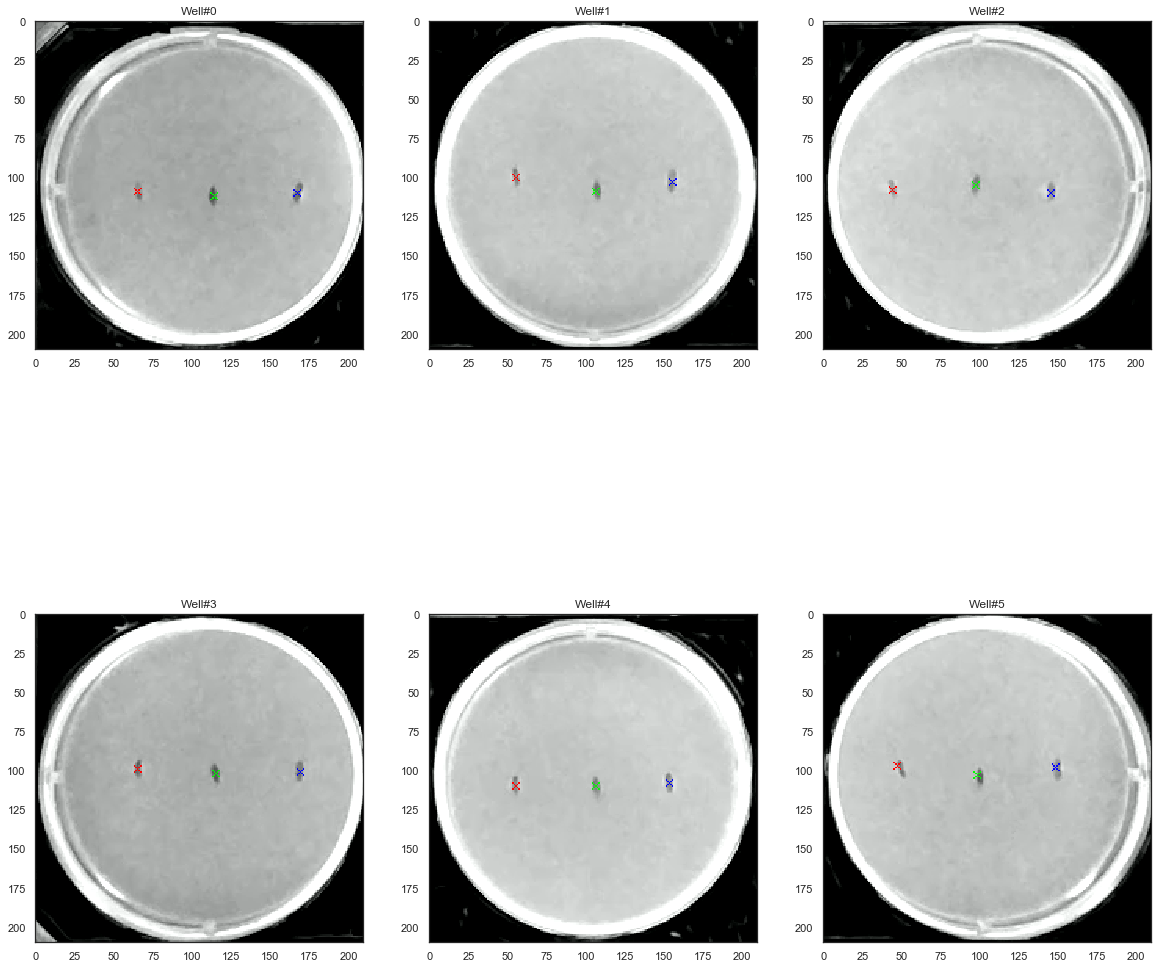

In [93]:
dnum=0
fmax=3
wmax=6

dirname=dirs[dnum]

index=['left_x','left_y','right_x','right_y','center_x','center_y']
targets=pd.DataFrame([],index=index)

cntr=0
for fnum in [1]:#range(fmax):
    fname=fnames[dnum][fnum]
    filepath=dirname+'/'+fname
    #out_fname=fname+'-fg.avi'
    #out_fname='tmp.mov'
    f_head='.'.join(fname.split('.')[:-1])
    f_tail=fname.split('.')[-1]

    plt.figure(figsize=(20,20))

    for i in range(wmax):
        # 各種処理を変更（物体抽出、二値化、オープニングなど）する場合には、
        # in, outのファイル名を変更する必要がある。
        in_fname_base=f_head+'-well{}.'.format(str(i))+f_tail
        in_fname=dirname+'/'+in_fname_base
        out_fname=dirname+'/'+f_head+'-well{}-target.'.format(str(i))+'jpeg'
        #csv_fname=dirname+'/'+f_head+'-well{}.'.format(str(i))+'csv'

        #sys.exit()

        #print('IN File:{}'.format(in_fname))
        #print('OUT File:{}'.format(out_fname))
        #print('OUT CSV File:{}'.format(csv_fname))


        # 動画読み込みの設定
        movie = cv2.VideoCapture(in_fname)

        # 動画ファイル保存用の設定
        #fps = int(movie.get(cv2.CAP_PROP_FPS))                         # 動画のFPSを取得
        #framenum = int(movie.get(cv2.CAP_PROP_FRAME_COUNT))            # 動画のFrame数を取得
        #w = int(movie.get(cv2.CAP_PROP_FRAME_WIDTH))                   # 動画の横幅を取得
        #h = int(movie.get(cv2.CAP_PROP_FRAME_HEIGHT))                  # 動画の縦幅を取得
        #print('fps={},#frame={},w={},h={}'.format(fps,framenum,w,h))

        ret, frame = movie.read()                                  # フレームを取得
            
        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        lx=50
        ly=110
        rx=160
        ry=110
        cx=130
        cy=110

        if dnum==0:
            if i==0:   lx,ly,rx,ry,cx,cy=65,109,167,110,114,112
            elif i==1: lx,ly,rx,ry,cx,cy=55,100,155,103,106,109
            elif i==2: lx,ly,rx,ry,cx,cy=44,108,145,110,97,105
            elif i==3: lx,ly,rx,ry,cx,cy=65,99,169,101,115,102
            elif i==4: lx,ly,rx,ry,cx,cy=55,110,153,108,106,110
            elif i==5: lx,ly,rx,ry,cx,cy=47,97,148,98,98,103
        elif dnum==2:
            if i==0:   lx,ly,rx,ry,cx,cy=71,109,171,112,116,108
            elif i==1: lx,ly,rx,ry,cx,cy=59,101,159,103,107,103
            elif i==2: lx,ly,rx,ry,cx,cy=49,113,154,112,103,113
            elif i==3: lx,ly,rx,ry,cx,cy=65,99,170,104,116,105
            elif i==4: lx,ly,rx,ry,cx,cy=57,112,155,111,107,113
            elif i==5: lx,ly,rx,ry,cx,cy=48,102,154,105,97,107


        if 1:
            cv2.drawMarker(frame, (lx, ly), (255, 0, 0),
                           markerType=cv2.MARKER_TILTED_CROSS, markerSize=5)
            cv2.drawMarker(frame, (cx, cy), (0, 255, 0),
                           markerType=cv2.MARKER_TILTED_CROSS, markerSize=5)
            cv2.drawMarker(frame, (rx, ry), (0, 0, 255),
                           markerType=cv2.MARKER_TILTED_CROSS, markerSize=5)
        else:
            #cs=['green','magenta','cyan']
            rs=[15,20,25]
            for nn in range(len(rs)):
                cv2.circle(frame,(lx,ly),radius=rs[nn],color=(255,0,0))
                cv2.circle(frame,(rx,ry),radius=rs[nn],color=(255,0,0))

            
        plt.subplot(2,3,i+1)
        plt.imshow(frame)
        plt.title('Well#{}'.format(i))

        cntr+=1

        targets[in_fname_base]=pd.Series([lx,ly,rx,ry,cx,cy],index=index)




In [ ]:
cs[nn]

## 重心データの整形（未抽出フレームの処理など）

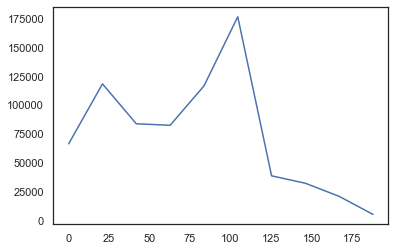

In [97]:
ox_org=grav['center_x'].values
oy_org=grav['center_y'].values
ps=grav['pixel_size'].values
zf=grav['zero_flg'].values
nf=grav['nan_flg'].values
ox=np.zeros_like(ox_org)
oy=np.zeros_like(oy_org)

pixel_size_thre=50
%timeit
for i in range(len(zf)):
    #if i%1000==0:
    #    print('i={}/{}'.format(i,len(zf)))
    if nf[i]==1: 
        ox[i]=cx
        oy[i]=cy
    else:
        if zf[i]==1 or ps[i]<pixel_size_thre:
            ox[i]=ox_pre
            oy[i]=oy_pre
        else:
            ox[i]=ox_org[i]
            oy[i]=oy_org[i]
    ox_pre=ox[i]
    oy_pre=oy[i]


a,b=np.histogram(ox)
plt.plot(b[:-1],a)      

## 重心の時系列データを読み込んで解析

#### （被接近対象のスクリプトと重心データの整形を走らせた後に走らせる） 

/Users/siu/anaconda3/envs/courtship-behav/lib/python3.7/site-packages/ipykernel_launcher.py:368: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


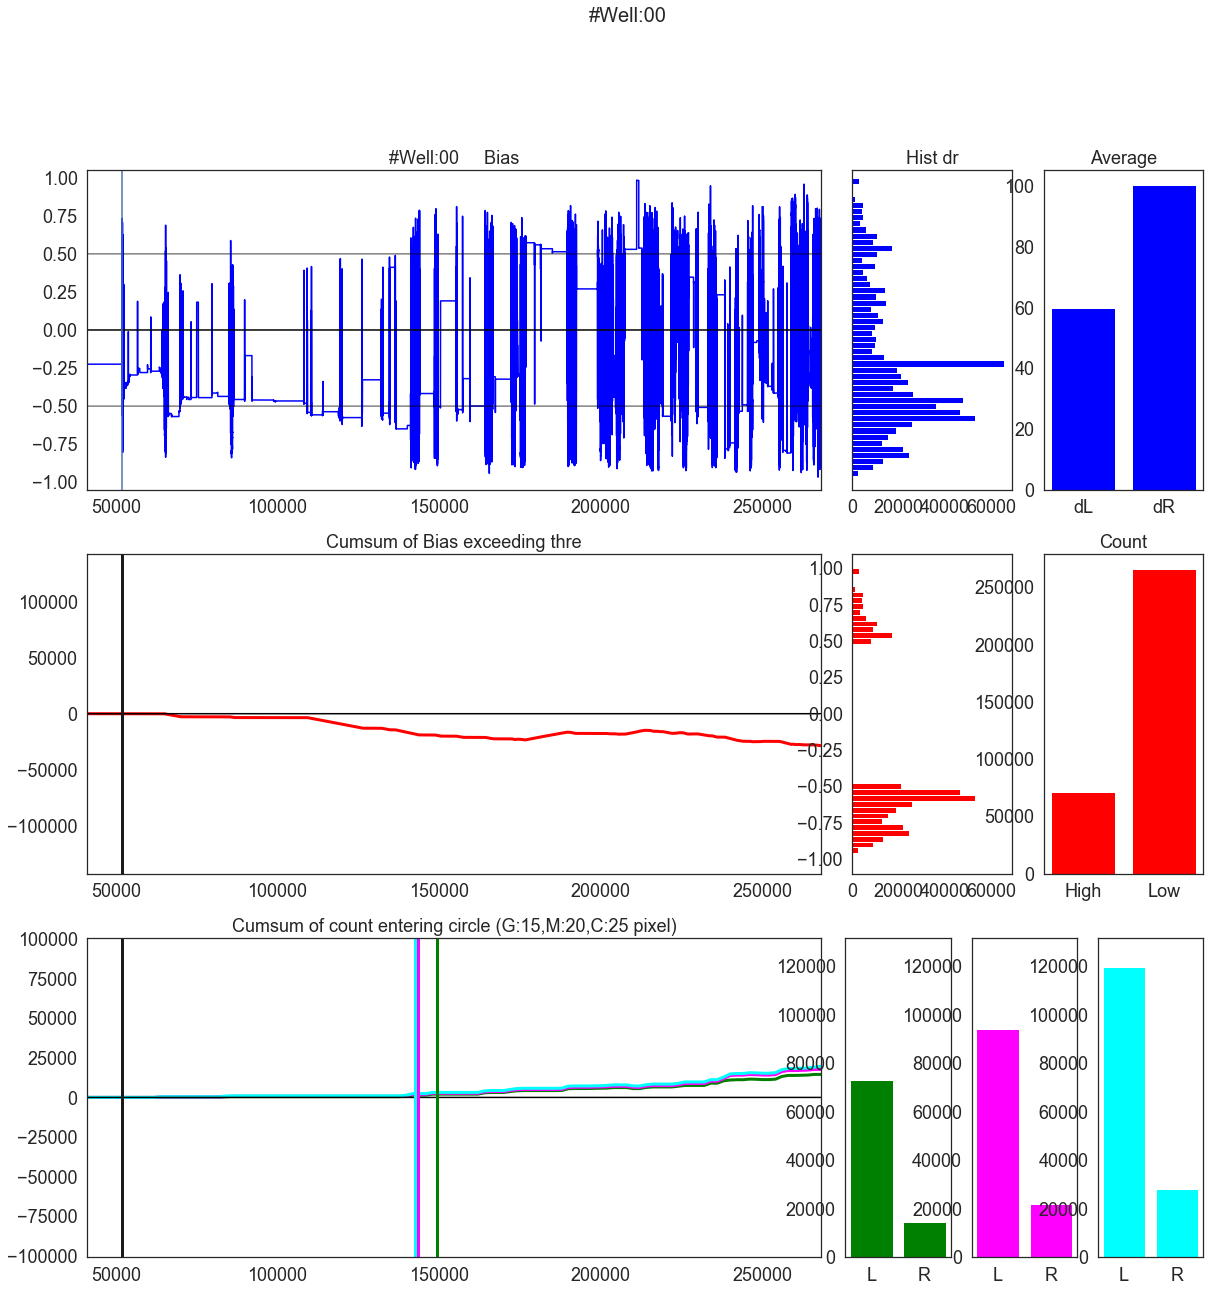

/Users/siu/anaconda3/envs/courtship-behav/lib/python3.7/site-packages/ipykernel_launcher.py:368: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


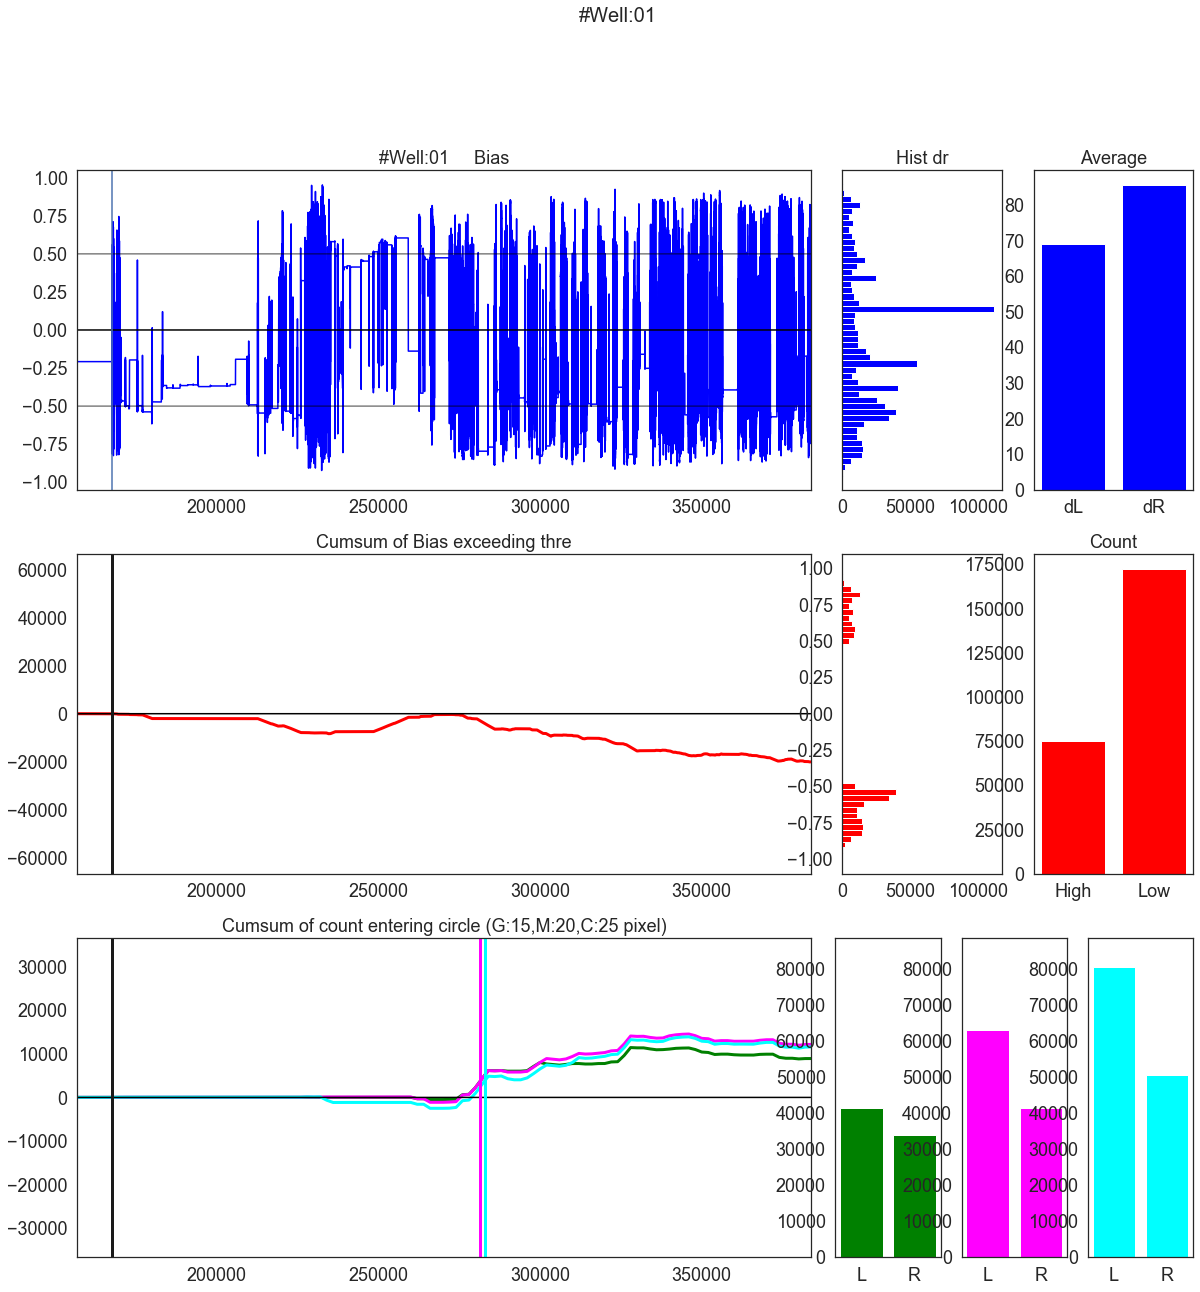

/Users/siu/anaconda3/envs/courtship-behav/lib/python3.7/site-packages/ipykernel_launcher.py:368: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


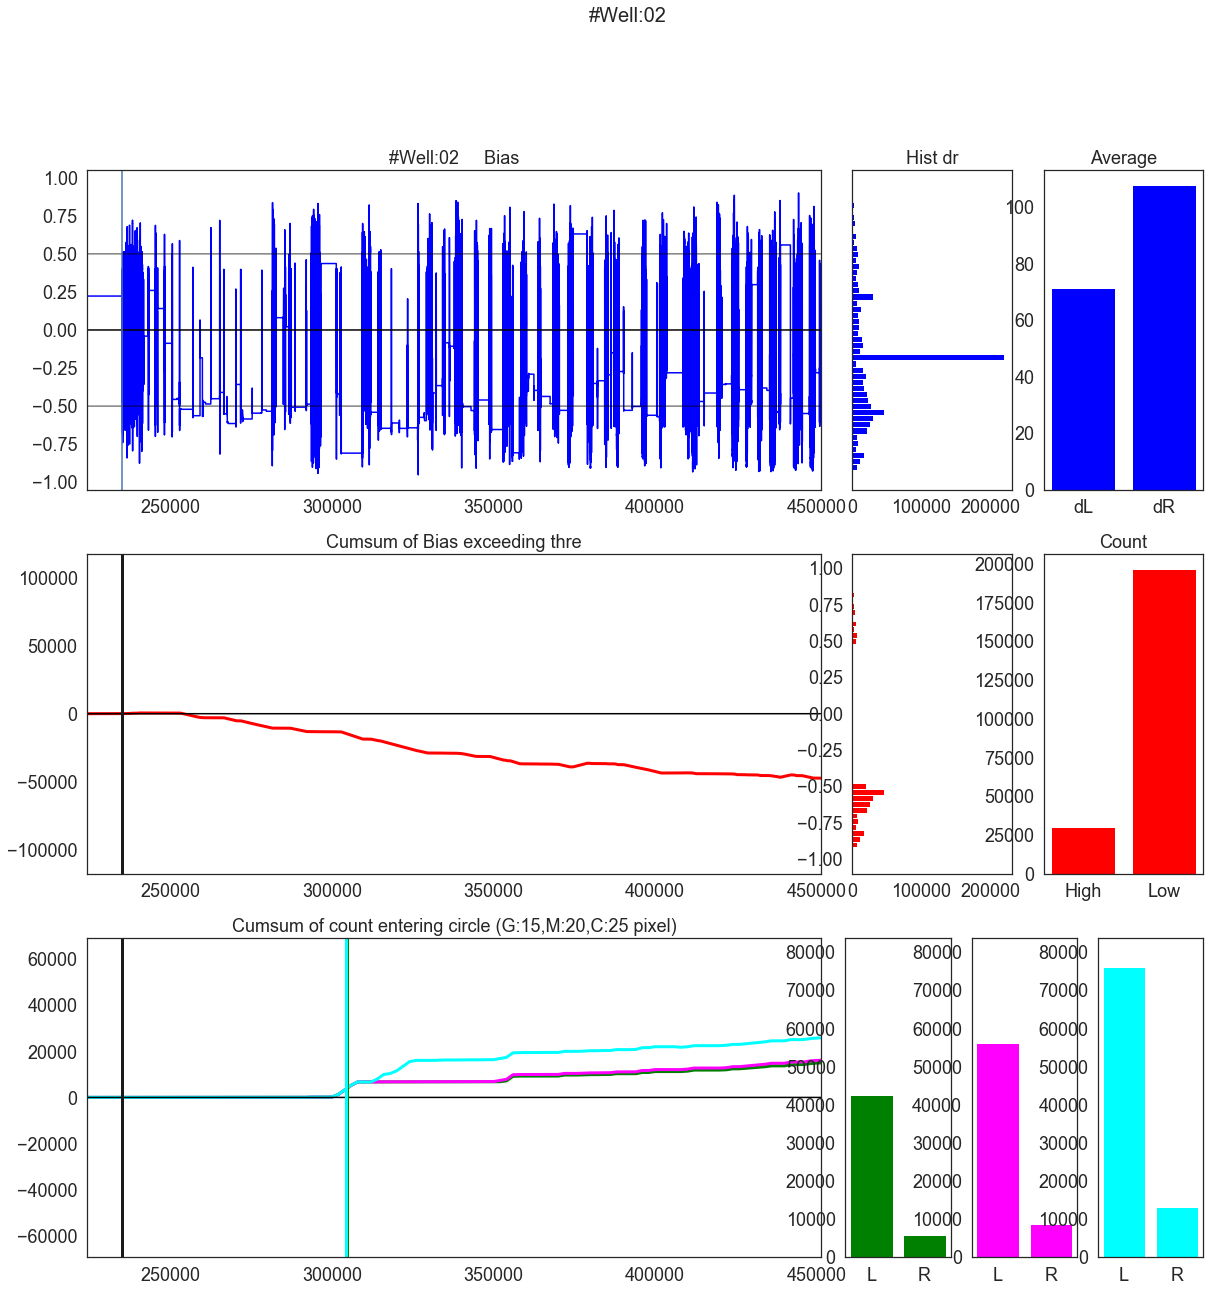

/Users/siu/anaconda3/envs/courtship-behav/lib/python3.7/site-packages/ipykernel_launcher.py:368: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


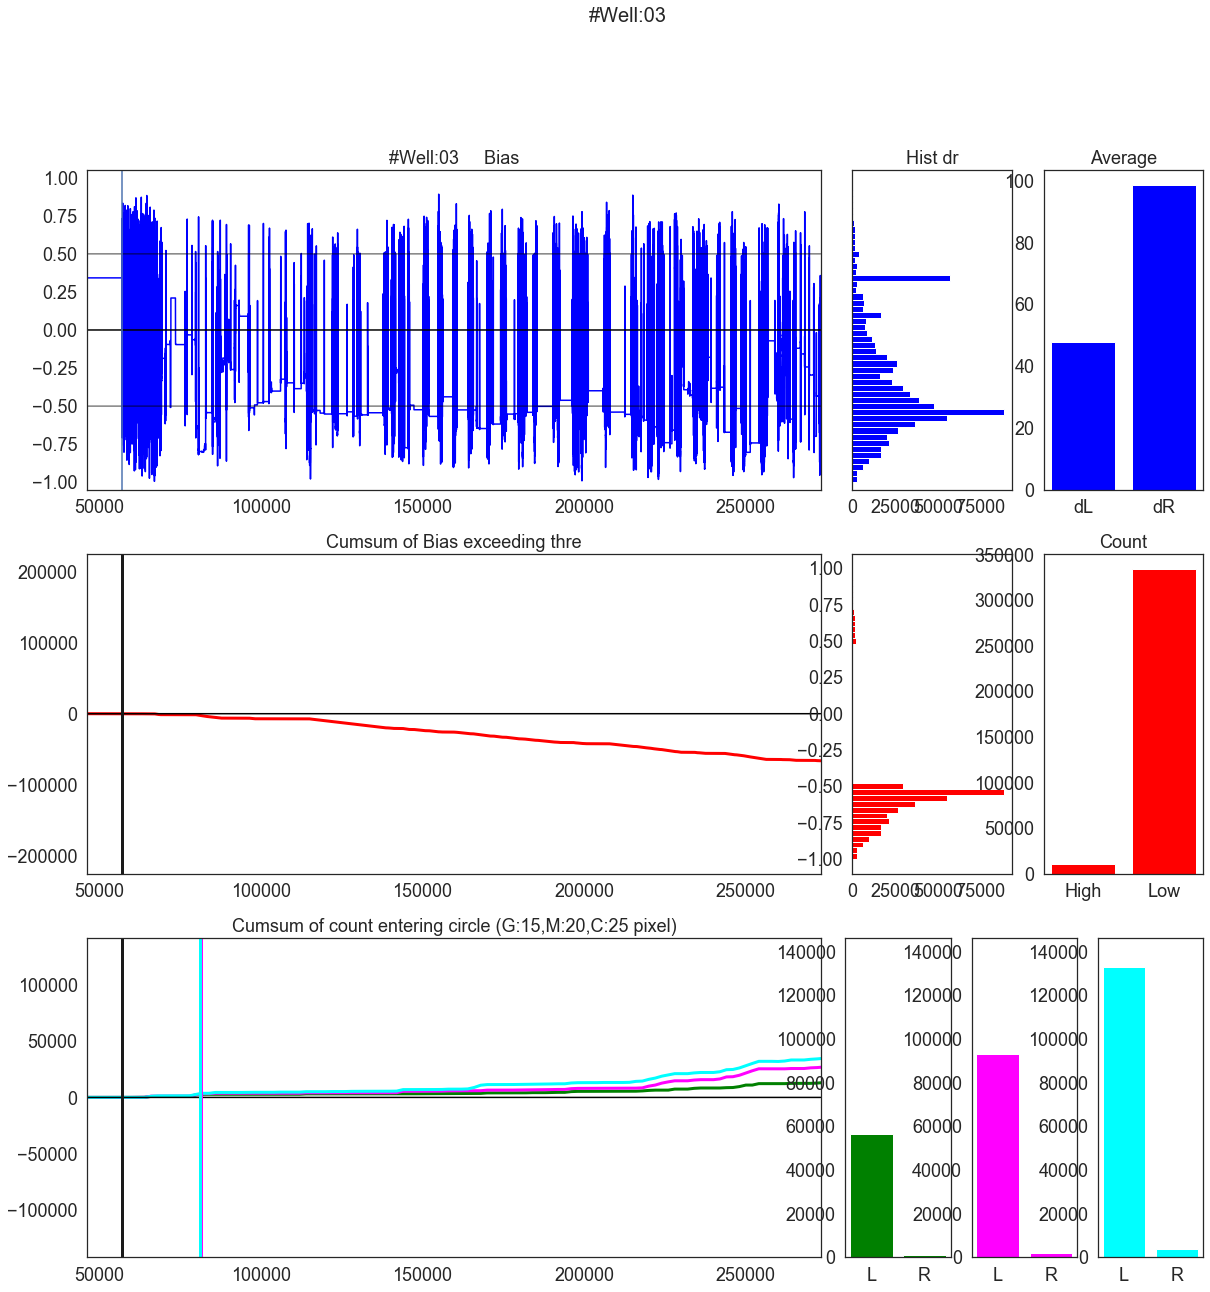

/Users/siu/anaconda3/envs/courtship-behav/lib/python3.7/site-packages/ipykernel_launcher.py:368: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


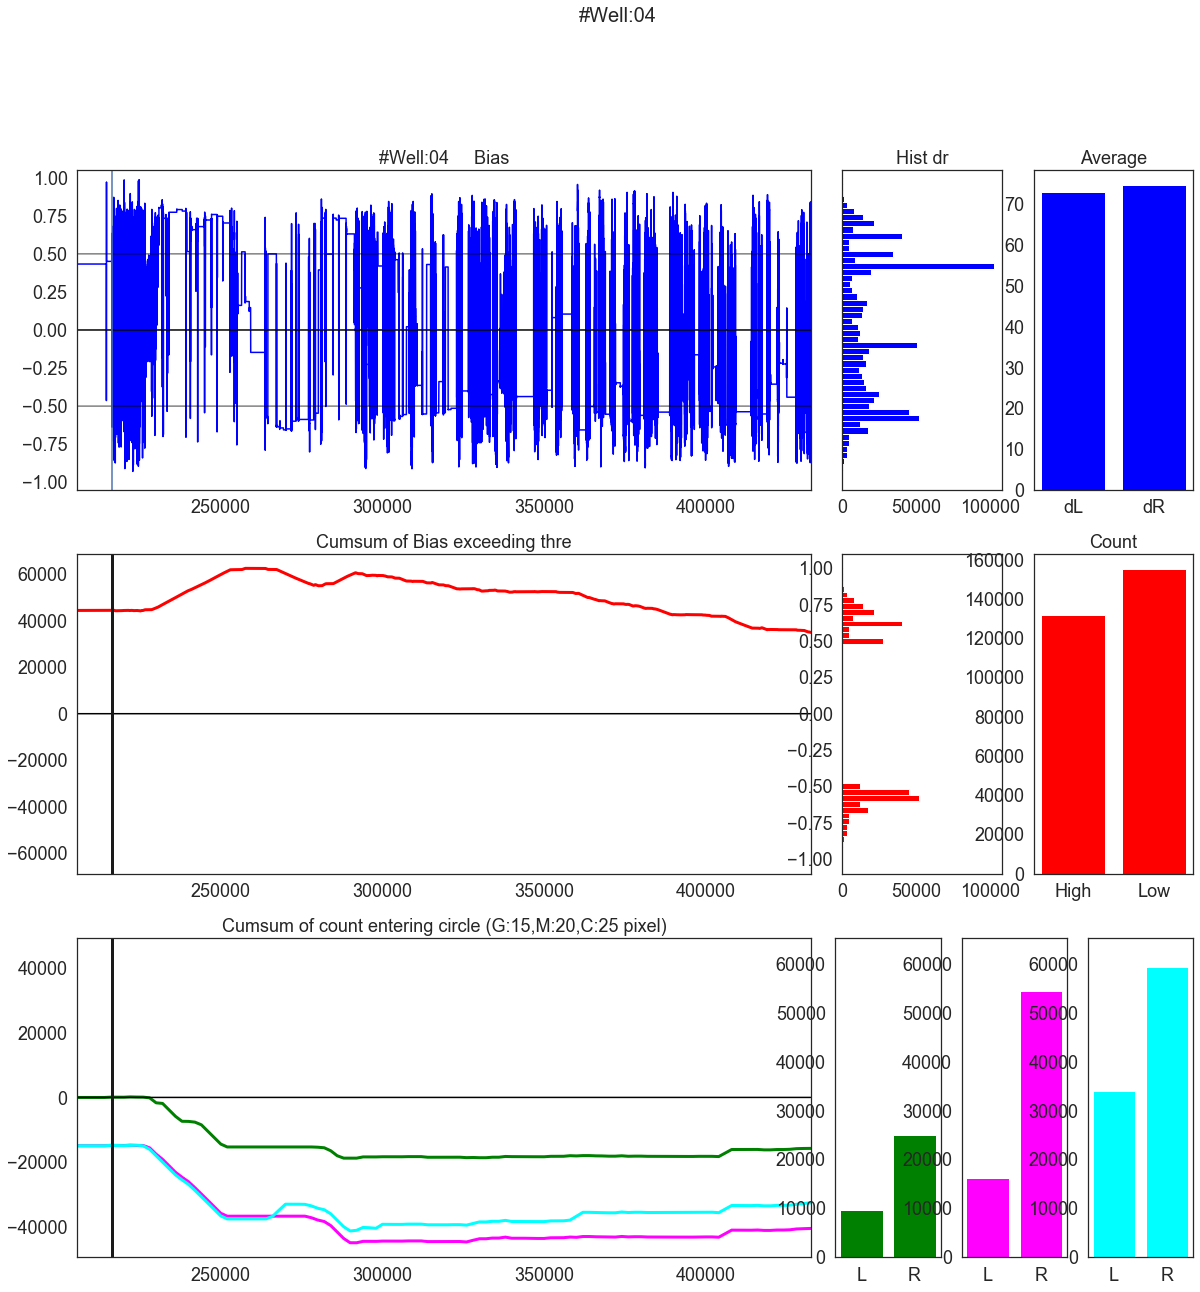

/Users/siu/anaconda3/envs/courtship-behav/lib/python3.7/site-packages/ipykernel_launcher.py:368: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.


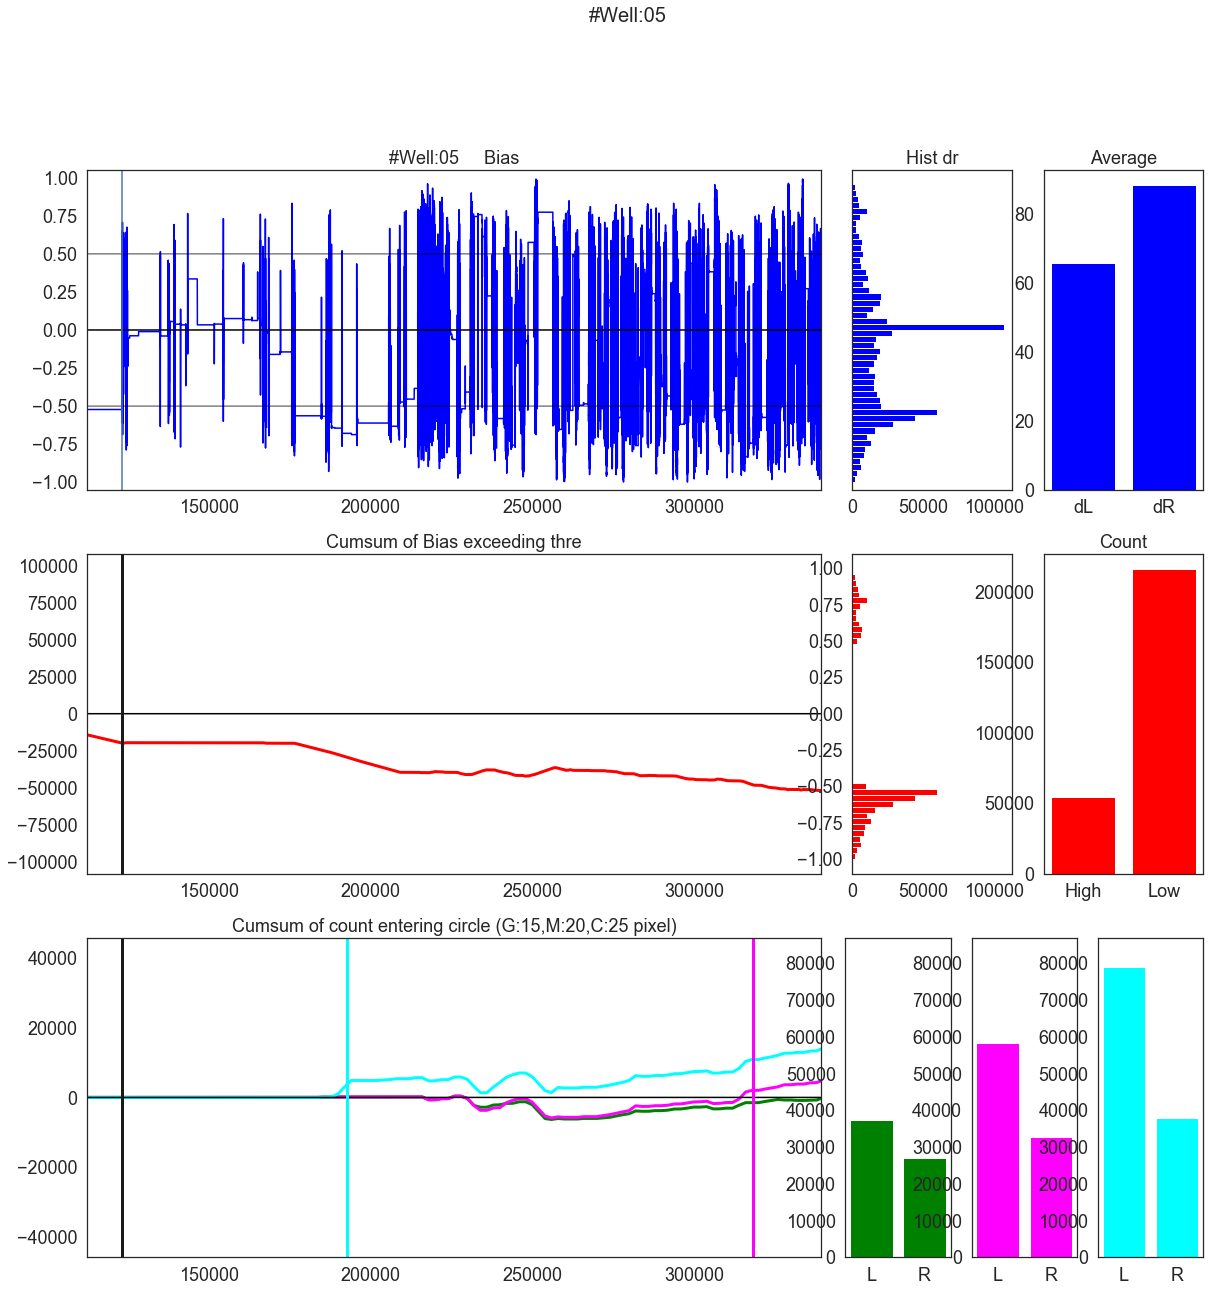

done.


In [139]:
dnum=0
fmax=3
wmax=6

dirname=dirs[dnum]

def get_gravities(wellnum):
    cntr=0
    for fnum in [1,2,3]:#range(fmax):
        fname=fnames[dnum][fnum]
        filepath=dirname+'/'+fname
        #out_fname=fname+'-fg.avi'
        #out_fname='tmp.mov'
        f_head='.'.join(fname.split('.')[:-1])
        f_tail=fname.split('.')[-1]

        in_fname_base=f_head+'-well{}.'.format(str(wellnum))+f_tail
        in_fname=dirname+'/'+in_fname_base
        csv_fname=dirname+'/'+f_head+'-well{}.'.format(str(wellnum))+'csv'
        #print(in_fname)

        tmp_csv=pd.read_csv(csv_fname)

        if cntr==0:
            grav=tmp_csv
            v=targets[in_fname_base]
            target_loc=v
        else:
            grav=pd.concat([grav,tmp_csv])        
        
        cntr+=1
    
    grav.reset_index(drop=True)
    return grav,target_loc

#grav,target_loc=get_gravities(0)
#sys.exit()

# 以下の関数は、重心時系列の取得をするもの
# 背景の次に大きいオブジェクトを重心とするが、
# そのサイズが小さい場合切り捨て、動いていないとみなす
#（直前フレームの重心を継承）
def mod_gravities(grav):
    ox_org=grav['center_x'].values
    oy_org=grav['center_y'].values
    ps=grav['pixel_size'].values
    zf=grav['zero_flg'].values
    nf=grav['nan_flg'].values
    ox=np.zeros_like(ox_org)
    oy=np.zeros_like(oy_org)

    pixel_size_thre=50
    for i in range(len(zf)):
        #if i%1000==0:
        #    print('i={}/{}'.format(i,len(zf)))
        if nf[i]==1: 
            ox[i]=cx
            oy[i]=cy
        else:
            if zf[i]==1 or ps[i]<pixel_size_thre:
                ox[i]=ox_pre
                oy[i]=oy_pre
            else:
                ox[i]=ox_org[i]
                oy[i]=oy_org[i]
        ox_pre=ox[i]
        oy_pre=oy[i]
    return ox,oy
        
wnum=6


# 被接近対象の半径Xピクセル内に進入した回数をカウント
def count_entering(dl,dr,thre):
    ind1=np.where(dl<=thre)[0]
    ind2=np.where(dr<=thre)[0]
    x=np.zeros(len(dl))
    x[ind1]=1
    x[ind2]=-1
    n1=len(ind1)
    n2=len(ind2)
    return x,n1,n2

# グラフの整形のためのもの
def set_fontsize(ax,fontsize):
    itemsx=ax.get_xticklabels()
    itemsy=ax.get_yticklabels()
    for i in range(len(itemsx)):
        itemsx[i].set_fontsize(fontsize)
    for i in range(len(itemsy)):
        itemsy[i].set_fontsize(fontsize)

        
dl_mean=np.zeros(wnum)
dl_std=np.zeros(wnum)
dr_mean=np.zeros(wnum)
dr_std=np.zeros(wnum)
distances=pd.DataFrame()

n1s=np.array([])
n2s=np.array([])

# eclosionの目視判定
if dnum==0:
    eclos=['04:48:42','15:31:23','21:46:17','05:17:15','20:02:12','11:24:28'] # by Kang
elif dnum==2:
    eclos=['17:00:27','15:24:53','19:48:13','21:24:68','19:53:35','19:39:39'] # by Kang


fps=3
eclo_frames=np.zeros(wnum)
for i in range(len(eclos)):
    tmp=eclos[i]
    h,m,s=tmp.split(':')
    hs=np.int(h)*3600
    ms=np.int(m)*60
    ss=np.int(s)
    alls=hs+ms+ss
    eclo_frames[i]=alls*fps


# グラフ描画の範囲指定    
dt_pre=3600*1 # eclosionから前1時間分
dt_post=3600*20 # eclosion後20時間分
dframe_pre=dt_pre*fps
dframe_post=dt_post*fps

disp_short=1
# ********************************************
cntr=0
arr_all=np.array([])
icntr=0
for i in range(2): # for image placement
    arrs=np.array([])
    jcntr=0    
    for j in range(3): # for image placement
        fig = plt.figure(figsize=(20,20))
        disp_range=[eclo_frames[cntr]-dframe_pre,eclo_frames[cntr]+dframe_post]
        if disp_range==1:
            f1=np.int(disp_range[0])
            f2=np.int(disp_range[1])
        else:
            f1=0
            f2=len(ox)
            
        wellnum=str(cntr).zfill(2)
        #fname=h+wellnum+'.csv'
        #dat=pd.read_csv(fname,header=None)
        #data=pd.DataFrame(dat.values,columns=['y-coord','x-coord'])

        grav,tar_loc=get_gravities(cntr)
        ox,oy=mod_gravities(grav)
        lx=tar_loc['left_x']
        ly=tar_loc['left_y']
        rx=tar_loc['right_x']
        ry=tar_loc['right_y']

        #ox=grav['center_x'].values
        #oy=grav['center_y'].values

        dl=((ox-lx)**2+(oy-ly)**2)**0.5
        dr=((ox-rx)**2+(oy-ry)**2)**0.5
        
        #dl=((dat.values[:,0]-target_loc[cntr,0])**2+(dat.values[:,1]-target_loc[cntr,1])**2)**0.5
        #dr=((dat.values[:,0]-target_loc[cntr,2])**2+(dat.values[:,1]-target_loc[cntr,3])**2)**0.5
        
        dl_mean[cntr]=np.mean(dl)
        dl_std[cntr]=np.std(dl)
        dr_mean[cntr]=np.mean(dr)
        dr_std[cntr]=np.std(dr)

        w=np.ones(dl.size)*cntr
        df=pd.DataFrame(np.c_[dl,dr,w],columns=['dl','dr','well'])
        distances=pd.concat([distances,df])

        bias=(dl-dr)/(dl+dr)
        bias=pd.Series(bias)
        #bias=bias.rolling(window=30).mean()

        maxt=len(ox)
        sns.set(style="white", color_codes=True)
        
        xs=range(len(ox))
        # ***** Visualization *****
        #sns.jointplot(x='x-coord', y='y-coord', data=data, kind='kde') #kind=kde,hex
        fontsize=18

        if 0: # 滞在の時間分布の図を描画したい場合ここを1に。
            #ax=sns.jointplot(x=ox[::10],y=oy[::10],
            #                 xlim=(10,210),ylim=(10,210),kind='kde')
            #fig = plt.figure()
            ax = fig.add_subplot(111)

            H = ax.hist2d(ox[f1:f2],oy[f1:f2], 
                          bins=[np.linspace(0,210,84),np.linspace(0,210,84)],
                          normed=True)
            #ax.set_xlabel('x')
            #ax.set_ylabel('y')
            H[3].set_clim(0,0.0001)
            ax.set_aspect('equal')
            fig.colorbar(H[3],ax=ax)

            #plt.title('#Well:'+wellnum,fontsize=fontsize)


        else: # 以下は様々な統計を描画               
            bias_thre=0.5 # Bias value

            # *** 1st row ***            
            c='blue'
            ax=plt.subplot2grid((3,6),(0,0),colspan=4)
            lp=plt.plot(xs[f1:f2], bias.values[f1:f2], color=c)
            plt.plot(xs[f1:f2], np.zeros(f2-f1), color='black')
            plt.plot(xs[f1:f2], np.ones(f2-f1)*bias_thre, color='black',alpha=0.5)
            plt.plot(xs[f1:f2], np.ones(f2-f1)*(-bias_thre), color='black',alpha=0.5)
            plt.xlim((-1,maxt+1))
            plt.ylim((-1.05,1.05))
            plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-1.05,1.05])
            plt.title('#Well:'+wellnum+'     Bias',fontsize=fontsize)
            set_fontsize(ax,fontsize)
            if disp_short==1:
                plt.xlim(disp_range)

            ax=plt.subplot2grid((3,6),(0,4))
            plt.hist(bias.values[f1:f2],bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
            plt.title('Hist dr',fontsize=fontsize)
            plt.ylim(-1.05,1.05)
            set_fontsize(ax,fontsize)
            ax.set_yticklabels([])
            xl=ax.get_xlim()


            ax=plt.subplot2grid((3,6),(0,5))
            plt.bar([0,1],[np.mean(dl[f1:f2]),np.mean(dr[f1:f2])],color=c)
            ax.set_xticks([0,1])
            ax.set_xticklabels(['dL','dR'],fontsize=fontsize)
            plt.title('Average',fontsize=fontsize)
            set_fontsize(ax,fontsize)



            # *** 2st row ***
            c='red'
            ind1=np.where(bias.values[f1:f2]>=bias_thre)[0]
            ind2=np.where(bias.values[f1:f2]<=-bias_thre)[0]
            n1=len(ind1)
            n2=len(ind2)

            biasmod=np.copy(bias.values[f1:f2])
            ind=np.where((biasmod<bias_thre)&(biasmod>(-bias_thre)))[0]
            biasmod[ind]=0.0

            plotdata=np.cumsum(biasmod)
            ymax=np.max(np.abs(plotdata))
            ax=plt.subplot2grid((3,6),(1,0),colspan=4)
            lp=plt.plot(xs[f1:f2], plotdata, color=c,linewidth=3)
            plt.plot(xs, np.zeros(len(xs)), color='black')
            plt.ylim([-ymax*1.1,ymax*1.1])
            plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                     color='k',linewidth=3)
            plt.xlim((-1,maxt+1))
            plt.title('Cumsum of Bias exceeding thre',fontsize=fontsize)
            set_fontsize(ax,fontsize)
            if disp_short==1:
                plt.xlim(disp_range)


            ax=plt.subplot2grid((3,6),(1,4))
            plt.hist(np.r_[biasmod[ind1],biasmod[ind2]],bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
            set_fontsize(ax,fontsize)
            ax.set_xlim(xl)

            ax=plt.subplot2grid((3,6),(1,5))
            plt.bar([0,1],[n1,n2],color=c)
            ax.set_xticks([0,1])
            ax.set_xticklabels(['High','Low'],fontsize=fontsize)
            plt.title('Count',fontsize=fontsize)
            set_fontsize(ax,fontsize)



            # *** 3rd row ***
            thres=[15,20,25]
            if cntr==0:
                onset_frames=np.zeros((wnum,len(thres)))
            xx=np.zeros((len(thres),len(dl)))
            nn1=np.zeros(len(thres))
            nn2=np.zeros(len(thres))
            for ii in range(len(thres)):
                xx[ii,:],nn1[ii],nn2[ii]=count_entering(dl[f1:f2],dr[f1:f2],thres[ii])
            if cntr==0:
                n1s=nn1
                n2s=nn2
            else:
                n1s=np.c_[n1s,nn1]
                n2s=np.c_[n2s,nn2]

            cs=['green','magenta','cyan']
            ax=plt.subplot2grid((3,6),(2,0),colspan=4)
            if 0:
                for ii in range(len(thres)):
                    d=np.cumsum(xx[ii])
                    lp=plt.plot(xs, d, color=cs[ii],linewidth=3)
                    enter_count_thre=600*fps
                    ind=np.where(d>enter_count_thre)[0]
                    if len(ind)==0:
                        onset_frames[cntr,ii]=0
                    else:
                        onset_frames[cntr,ii]=ind[0]
            else:
                tmpmax=np.zeros_like(thres)
                for ii in range(len(thres)):
                    d=np.cumsum(xx[ii])
                    ind_l=np.where(xx[ii]==+1)[0]
                    ind_r=np.where(xx[ii]==-1)[0]

                    lv,b=np.histogram(ind_l,bins=range(0,f2-f1,2000))
                    #plt.plot(b[:-1],lv,linewidth=3,color=cs[ii])
                    rv,b=np.histogram(ind_r,bins=range(0,f2-f1,2000))
                    #plt.plot(b[:-1],-rv,linewidth=3,color=cs[ii])
                    #plt.plot(b[:-1],-rv+lv,linewidth=3,color=cs[ii])
                    tmpmax[ii]=np.max([np.max(np.abs(lv)),np.max(np.abs(rv))])

                    plotdata=np.cumsum(-rv+lv)
                    plt.plot(b[:-1],np.cumsum(-rv+lv),linewidth=3,color=cs[ii])
                    tmpmax[ii]=np.max(np.abs(plotdata))

                    
                    enter_count_thre=600*fps
                    ind=np.where(d>enter_count_thre)[0]
                    if len(ind)==0:
                        onset_frames[cntr,ii]=0
                    else:
                        onset_frames[cntr,ii]=ind[0]

            #ymax=np.max(np.abs(np.cumsum(xx[-1])))
            ymax=np.max(tmpmax)
            plt.plot(xs, np.zeros(len(xs)), color='black')
            plt.ylim([-ymax*1.1,ymax*1.1])
            for ii in range(len(thres)):        
                plt.plot([onset_frames[cntr,ii],onset_frames[cntr,ii]],
                         [-ymax*1.1,ymax*1.1],color=cs[ii],linewidth=3)
                
            plt.plot([eclo_frames[cntr],eclo_frames[cntr]],[-ymax*1.1,ymax*1.1],
                    color='k',linewidth=3)
            plt.xlim((-1,maxt+1))
            plt.title('Cumsum of count entering circle (G:15,M:20,C:25 pixel)',
                      fontsize=fontsize)
            set_fontsize(ax,fontsize)
            if disp_short==1:
                plt.xlim(disp_range)


            yl=np.max([np.max(nn1),np.max(nn2)])*1.1
            for ii in range(len(thres)):
                ax=plt.subplot2grid((3,9),(2,6+ii))
                plt.bar([0,1],[nn1[ii],nn2[ii]],color=cs[ii])
                set_fontsize(ax,fontsize)
                ax.set_xticks([0,1])
                ax.set_xticklabels(['L','R'],fontsize=fontsize)
                ax.set_ylim([0,yl])

                
        #sys.exit()
        # *************************
        
        imfname=dirname+'/'+'img'+wellnum+'.png'
        plt.savefig(imfname)
        arr=np.array(Image.open(imfname))
        if jcntr==0: arrs=arr
        else: arrs=np.hstack((arrs,arr))
        jcntr+=1
        
        plt.suptitle('#Well:'+wellnum,verticalalignment='bottom',fontsize=20)        

        plt.tight_layout()
        plt.show()
        
        cntr+=1
    if icntr==0: arr_all=arrs
    else: arr_all=np.vstack((arr_all,arrs))
    icntr+=1

pil_img = Image.fromarray(arr_all)
pil_img.save(dirname+'/'+'img-summary.png')

#plt.figure(figsize=(15, 15))
#ax = sns.violinplot(x=distances['well'], y=pkmn["dr"], split=True) 

print('done.')

In [126]:
f2

267966.0

In [ ]:
diff_frames=np.zeros_like(onset_frames)
plt.figure(figsize=(10,10))
for i in range(wnum):
    d=onset_frames[i,:]-eclo_frames[i]
    d=np.where(d<0,0,d)
    d=d/fps
    diff_frames[i,:]=d
    print(d)
    plt.subplot(2,3,i+1)
    plt.bar(thres,d,width=3)
diff_frames

In [ ]:
plt.bar([0,1,2],[10,11,8])

# 以下は古いコード（念のため保存） 

## 動画Croppingの例

In [ ]:
import ffmpeg

# 切り取りたい区画の座標（pixel）
upper_left_x = 0
upper_left_y = 0
width = 60
height = 60

stream = ffmpeg.input(filepath)
# sample.mp4に切り取りたい動画を入れる

stream = ffmpeg.crop(stream, upper_left_x, upper_left_y, width, height)
stream = ffmpeg.output(stream, out_fname)
# cropoutput.mp4が切り取った動画で出てきます。

ffmpeg.run(stream, overwrite_output=True)
# overwrite_output=Trueとすることで同じファイル名の動画がすでにあっても上書きします。

print('Trim finished!')

## 重心の時系列データを読み込んで解析（旧）

In [ ]:

target_fname='dispersion.csv'
tar=pd.read_csv(target_fname,header=None)
tar=tar.values
wnum=12
target_loc=np.zeros((wnum,4))
cntr=0
for i in range(wnum):
    c=i*2
    target_loc[i,0:2]=tar[c+1,:]
    target_loc[i,2:4]=tar[c,:]

#print(target_loc)

h='gravities_well'
def count_entering(dl,dr,thre):
    ind1=np.where(dl<=thre)[0]
    ind2=np.where(dr<=thre)[0]
    x=np.zeros(len(dl))
    x[ind1]=1
    x[ind2]=-1
    n1=len(ind1)
    n2=len(ind2)
    return x,n1,n2

def set_fontsize(ax,fontsize):
    itemsx=ax.get_xticklabels()
    itemsy=ax.get_yticklabels()
    for i in range(len(itemsx)):
        itemsx[i].set_fontsize(fontsize)
    for i in range(len(itemsy)):
        itemsy[i].set_fontsize(fontsize)

        
dl_mean=np.zeros(wnum)
dl_std=np.zeros(wnum)
dr_mean=np.zeros(wnum)
dr_std=np.zeros(wnum)
distances=pd.DataFrame()

n1s=np.array([])
n2s=np.array([])


cntr=0
arr_all=np.array([])
icntr=0
for i in range(3):
    arrs=np.array([])
    jcntr=0    
    for j in range(4):
        fig = plt.figure(figsize=(20,20))

        wellnum=str(cntr).zfill(2)
        fname=h+wellnum+'.csv'
        dat=pd.read_csv(fname,header=None)
        data=pd.DataFrame(dat.values,columns=['y-coord','x-coord'])

        dl=((dat.values[:,0]-target_loc[cntr,0])**2+(dat.values[:,1]-target_loc[cntr,1])**2)**0.5
        dr=((dat.values[:,0]-target_loc[cntr,2])**2+(dat.values[:,1]-target_loc[cntr,3])**2)**0.5
        
        dl_mean[cntr]=np.mean(dl)
        dl_std[cntr]=np.std(dl)
        dr_mean[cntr]=np.mean(dr)
        dr_std[cntr]=np.std(dr)

        w=np.ones(dl.size)*cntr
        df=pd.DataFrame(np.c_[dl,dr,w],columns=['dl','dr','well'])
        distances=pd.concat([distances,df])

        bias=(dl-dr)/(dl+dr)
        bias=pd.Series(bias)
        #bias=bias.rolling(window=30).mean()

        maxt=len(data)
        sns.set(style="white", color_codes=True)
        
        xs=range(len(dat.values))
        # ***** Visualization *****
        #sns.jointplot(x='x-coord', y='y-coord', data=data, kind='kde') #kind=kde,hex
        fontsize=18
        c='blue'

        
        # *** 1st row ***
        if 0:
            ax=sns.jointplot(x=ox[::100],y=oy[::100],
                             xlim=(10,220),ylim=(10,220),kind='kde')
            plt.title('#Well:'+wellnum,fontsize=fontsize)

        else:
            ax=plt.subplot2grid((3,6),(0,0),colspan=4)
            lp=plt.plot(xs, bias.values, color=c)
            plt.plot(xs, np.zeros(len(xs)), color='black')
            plt.plot(xs, np.ones(len(xs))*thre, color='black',alpha=0.5)
            plt.plot(xs, np.ones(len(xs))*(-thre), color='black',alpha=0.5)
            plt.xlim((-1,maxt+1))
            plt.ylim((-1.05,1.05))
            plt.title('#Well:'+wellnum+'     Bias',fontsize=fontsize)
            set_fontsize(ax,fontsize)


            ax=plt.subplot2grid((3,6),(0,4))
            plt.hist(bias.values,bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
            plt.title('Hist dr',fontsize=fontsize)
            plt.ylim(-1.05,1.05)
            set_fontsize(ax,fontsize)
            ax.set_yticklabels([])
            xl=ax.get_xlim()


            ax=plt.subplot2grid((3,6),(0,5))
            plt.bar([0,1],[np.mean(dl),np.mean(dr)],color=c)
            ax.set_xticks([0,1])
            ax.set_xticklabels(['dL','dR'],fontsize=fontsize)
            plt.title('Average',fontsize=fontsize)
            set_fontsize(ax,fontsize)



            # *** 2st row ***
            c='red'
            thre=0.5 # Bias value
            ind1=np.where(bias.values>=thre)[0]
            ind2=np.where(bias.values<=-thre)[0]
            n1=len(ind1)
            n2=len(ind2)

            biasmod=np.copy(bias.values)
            ind=np.where((biasmod<thre)&(biasmod>(-thre)))[0]
            biasmod[ind]=0.0

            plotdata=np.cumsum(biasmod)
            ymax=np.max(np.abs(plotdata))
            ax=plt.subplot2grid((3,6),(1,0),colspan=4)
            lp=plt.plot(xs, plotdata, color=c,linewidth=3)
            plt.plot(xs, np.zeros(len(xs)), color='black')
            plt.ylim([-ymax*1.1,ymax*1.1])
            plt.xlim((-1,maxt+1))
            plt.title('Cumsum of Bias exceeding thre',fontsize=fontsize)
            set_fontsize(ax,fontsize)


            ax=plt.subplot2grid((3,6),(1,4))
            plt.hist(np.r_[biasmod[ind1],biasmod[ind2]],bins=50,range=(-1.0,1.0),orientation='horizontal',color=c)
            set_fontsize(ax,fontsize)
            ax.set_xlim(xl)

            ax=plt.subplot2grid((3,6),(1,5))
            plt.bar([0,1],[n1,n2],color=c)
            ax.set_xticks([0,1])
            ax.set_xticklabels(['High','Low'],fontsize=fontsize)
            plt.title('Count',fontsize=fontsize)
            set_fontsize(ax,fontsize)



            # *** 3rd row ***
            thres=[15,20,25]
            xx=np.zeros((len(thres),len(dl)))
            nn1=np.zeros(len(thres))
            nn2=np.zeros(len(thres))
            for ii in range(len(thres)):
                xx[ii,:],nn1[ii],nn2[ii]=count_entering(dl,dr,thres[ii])
            if cntr==0:
                n1s=nn1
                n2s=nn2
            else:
                n1s=np.c_[n1s,nn1]
                n2s=np.c_[n2s,nn2]

            cs=['green','magenta','cyan']
            ax=plt.subplot2grid((3,6),(2,0),colspan=4)
            for ii in range(len(thres)):
                lp=plt.plot(xs, np.cumsum(xx[ii]), color=cs[ii],linewidth=3)
            ymax=np.max(np.abs(np.cumsum(xx[-1])))
            plt.plot(xs, np.zeros(len(xs)), color='black')
            plt.ylim([-ymax*1.1,ymax*1.1])
            plt.xlim((-1,maxt+1))
            plt.title('Cumsum of count entering circle (G:15,M:20,C:25 pixel)',fontsize=fontsize)
            set_fontsize(ax,fontsize)

            yl=np.max([np.max(nn1),np.max(nn2)])*1.1
            for ii in range(len(thres)):
                ax=plt.subplot2grid((3,9),(2,6+ii))
                plt.bar([0,1],[nn1[ii],nn2[ii]],color=cs[ii])
                set_fontsize(ax,fontsize)
                ax.set_xticks([0,1])
                ax.set_xticklabels(['L','R'],fontsize=fontsize)
                ax.set_ylim([0,yl])

                
        #sys.exit()
        # *************************
        
        imfname='img'+wellnum+'.png'
        plt.savefig(imfname)
        arr=np.array(Image.open(imfname))
        if jcntr==0: arrs=arr
        else: arrs=np.hstack((arrs,arr))
        jcntr+=1
        
        plt.suptitle('#Well:'+wellnum,verticalalignment='bottom',fontsize=20)        

        plt.tight_layout()
        plt.show()
        
        cntr+=1
    if icntr==0: arr_all=arrs
    else: arr_all=np.vstack((arr_all,arrs))
    icntr+=1

pil_img = Image.fromarray(arr_all)
pil_img.save('./img-summary.png')

#plt.figure(figsize=(15, 15))
#ax = sns.violinplot(x=distances['well'], y=pkmn["dr"], split=True) 

print('done.')

In [ ]:
import cv2

In [ ]:
plt.figure(figsize=(15, 15))
x1=distances['well'].values
y1=distances['dr'].values
x2=distances['well'].values+wnum
y2=distances['dl'].values

#ax = sns.boxplot(x=distances['well'], y=distances['dl'])
ax = sns.boxplot(x=np.r_[x1,x2], y=np.r_[y1,y2])
